In [92]:
# Loading and installing the required libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import shap

In [93]:
# Load Dataset
data = pd.read_csv("filled_cybersecurity_data.csv")

# Preview Dataset
data.head()

,Unnamed: 0,Timestamp,Source.IP.Address,Destination.IP.Address,Source.Port,Destination.Port,Protocol,Packet.Length,Packet.Type,Traffic.Type,...,Action.Taken,Severity.Level,User.Information,Device.Information,Network.Segment,Geo.location.Data,Proxy.Information,Firewall.Logs,IDS.IPS.Alerts,Log.Source
0,1,2023-05-30 06:33:58,103.216.15.12,84.9.164.252,31225,17616,ICMP,503,Data,HTTP,...,Logged,Low,Reyansh Dugal,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment A,"Jamshedpur, Sikkim",150.9.97.135,Log Data,No Alert Data,Server
1,2,2020-08-26 07:08:30,78.199.217.198,66.191.137.154,17245,48166,ICMP,1174,Data,HTTP,...,Blocked,Low,Sumer Rana,Mozilla/5.0 (compatible; MSIE 8.0; Windows NT ...,Segment B,"Bilaspur, Nagaland",No Proxy Info,Log Data,No Alert Data,Firewall
2,3,2022-11-13 08:23:25,63.79.210.48,198.219.82.17,16811,53600,UDP,306,Control,HTTP,...,Ignored,Low,Himmat Karpe,Mozilla/5.0 (compatible; MSIE 9.0; Windows NT ...,Segment C,"Bokaro, Rajasthan",114.133.48.179,Log Data,Alert Data,Firewall
3,4,2023-07-02 10:38:46,163.42.196.10,101.228.192.255,20018,32534,UDP,385,Data,HTTP,...,Blocked,Medium,Fateh Kibe,Mozilla/5.0 (Macintosh; PPC Mac OS X 10_11_5; ...,Segment B,"Jaunpur, Rajasthan",No Proxy Info,NaN,Alert Data,Firewall
4,5,2023-07-16 13:11:07,71.166.185.76,189.243.174.238,6131,26646,TCP,1462,Data,DNS,...,Blocked,Low,Dhanush Chad,Mozilla/5.0 (compatible; MSIE 5.0; Windows NT ...,Segment C,"Anantapur, Tripura",149.6.110.119,NaN,Alert Data,Firewall


In [94]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              40000 non-null  int64  
 1   Timestamp               40000 non-null  object 
 2   Source.IP.Address       40000 non-null  object 
 3   Destination.IP.Address  40000 non-null  object 
 4   Source.Port             40000 non-null  int64  
 5   Destination.Port        40000 non-null  int64  
 6   Protocol                40000 non-null  object 
 7   Packet.Length           40000 non-null  int64  
 8   Packet.Type             40000 non-null  object 
 9   Traffic.Type            40000 non-null  object 
 10  Payload.Data            40000 non-null  object 
 11  Malware.Indicators      40000 non-null  object 
 12  Anomaly.Scores          40000 non-null  float64
 13  Alerts.Warnings         40000 non-null  object 
 14  Attack.Type             40000 non-null

In [95]:
# Check for missing values
print(data.isnull().sum())

Unnamed: 0                    0
Timestamp                     0
Source.IP.Address             0
Destination.IP.Address        0
Source.Port                   0
Destination.Port              0
Protocol                      0
Packet.Length                 0
Packet.Type                   0
Traffic.Type                  0
Payload.Data                  0
Malware.Indicators            0
Anomaly.Scores                0
Alerts.Warnings               0
Attack.Type                   0
Attack.Signature              0
Action.Taken                  0
Severity.Level                0
User.Information              0
Device.Information            0
Network.Segment               0
Geo.location.Data             0
Proxy.Information             0
Firewall.Logs             19961
IDS.IPS.Alerts                0
Log.Source                    0
dtype: int64


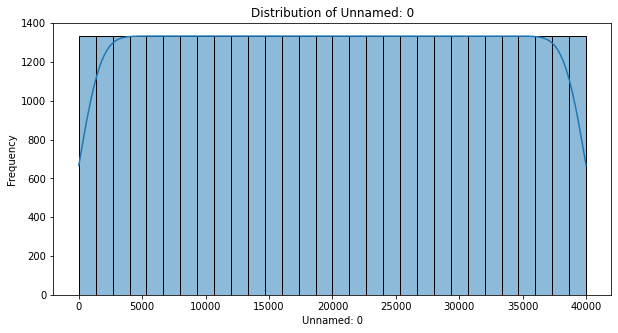

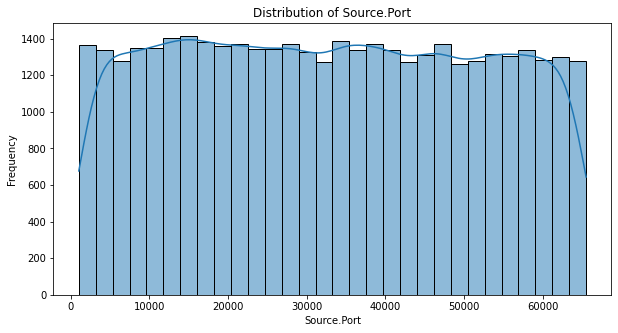

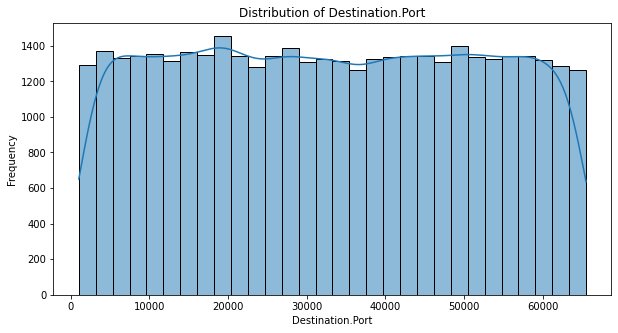

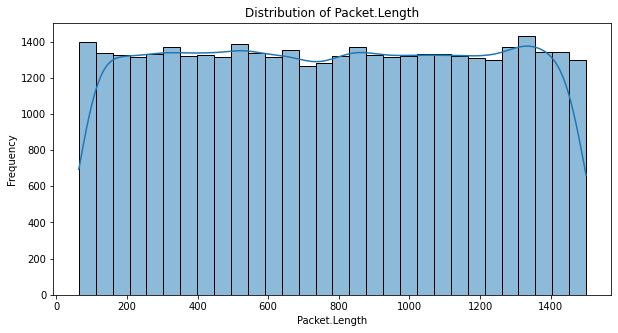

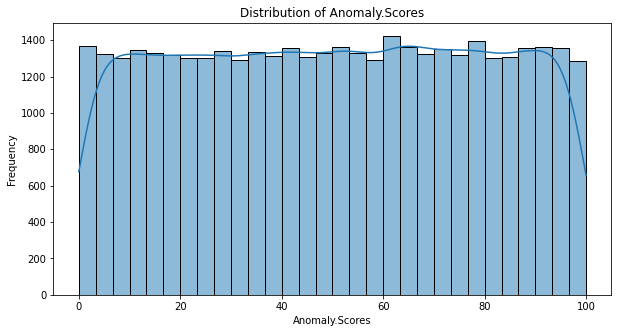

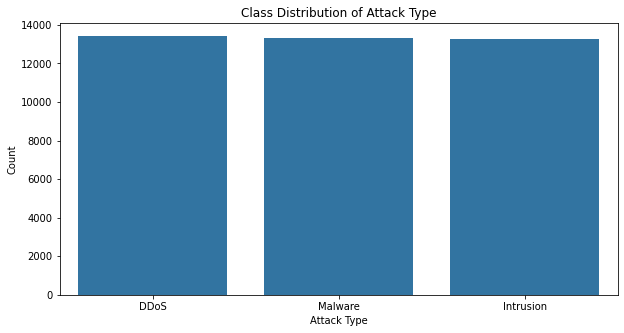

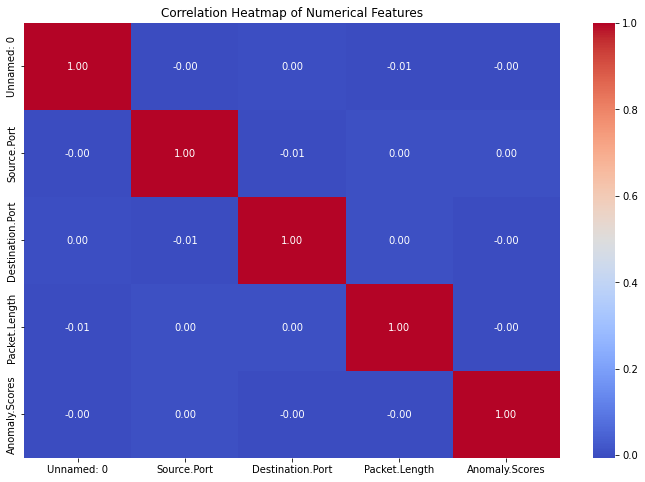

In [96]:
# EDA: Explore Distributions of Numerical Features
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns
for feature in numerical_features:
    plt.figure(figsize=(10, 5))
    sns.histplot(data[feature], kde=True, bins=30)
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

# EDA: Class Distribution for Target Variable
plt.figure(figsize=(10, 5))
sns.countplot(x='Attack.Type', data=data, order=data['Attack.Type'].value_counts().index)
plt.title("Class Distribution of Attack Type")
plt.xlabel("Attack Type")
plt.ylabel("Count")
plt.show()

# EDA: Correlation Heatmap
plt.figure(figsize=(12, 8))
numeric_columns = data.select_dtypes(include=['int64', 'float64']).columns
correlation_matrix = data[numeric_columns].corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

In [97]:
# Handle missing data
data = data.drop(columns=['Firewall.Logs'])

# Encode target variable 'Attack Type'
le = LabelEncoder()
data['Attack.Type'] = le.fit_transform(data['Attack.Type'])

# Drop high-cardinality features
data = data.drop(columns=['Source.IP.Address', 'Destination.IP.Address', 'Timestamp', 'Payload.Data'])

# Label encode remaining categorical features
categorical_features = data.select_dtypes(include=['object']).columns
for feature in categorical_features:
    data[feature] = le.fit_transform(data[feature])

# Separate features (X) and target (y)
X = data.drop(columns=['Attack.Type'])
y = data['Attack.Type']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [98]:
# Balance classes by undersampling majority classes
train_data = pd.concat([X_train, y_train], axis=1)
class_count = train_data['Attack.Type'].value_counts()
min_class_size = class_count.min()

# Downsample majority classes
balanced_train_data = pd.concat(
    [resample(train_data[train_data['Attack.Type'] == cls],
              replace=False, # no replacement
              n_samples=min_class_size, # match minority class size
              random_state=42)
    for cls in class_count.index]
)

# Separate features and target after balancing
X_train_balanced = balanced_train_data.drop(columns=['Attack.Type'])
y_train_balanced = balanced_train_data['Attack.Type']

In [99]:
# Normalize Numerical Features
numerical_features = X_train_balanced.select_dtypes(include=['int64', 'float64']).columns

scaler = StandardScaler()
X_train_balanced[numerical_features] = scaler.fit_transform(X_train_balanced[numerical_features])
X_test[numerical_features] = scaler.transform(X_test[numerical_features])

In [100]:
# Validation After Preprocessing
print("Validation: Shape of Datasets")
print("Before Balancing:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("After Balancing:")
print("X_train_balanced:", X_train_balanced.shape)
print("y_train_balanced Distribution:")
print(y_train_balanced.value_counts())

print("Sample of Normalized Data:")
print(X_train_balanced.head())

Validation: Shape of Datasets
Before Balancing:
X_train: (32000, 20)
X_test: (8000, 20)
After Balancing:
X_train_balanced: (31836, 20)
y_train_balanced Distribution:
0    10612
2    10612
1    10612
Name: Attack.Type, dtype: int64
Sample of Normalized Data:
       Unnamed: 0  Source.Port  Destination.Port  Protocol  Packet.Length  \
36865    1.464625    -0.793509          0.845456         1      -1.576196   
38446    1.601644    -1.614191          1.630740         2       1.056336   
19110   -0.074137     0.884311          1.260238         0      -1.388502   
32631    1.097679     1.699176         -1.588020         1      -0.772480   
20916    0.082382    -0.805410          1.448506         0       0.011986   

       Packet.Type  Traffic.Type  Malware.Indicators  Anomaly.Scores  \
36865            0             0                   1        0.740945   
38446            0             2                   0        0.852982   
19110            0             1                   1       -0.8